In [1]:
# ==============================#
# 0.  Install / import packages #
# ==============================#
!pip install fsspec s3fs 
!pip install --upgrade huggingface_hub

import re
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


2025-04-21 11:24:17.211076: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745213057.265403   50762 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745213057.276368   50762 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745213057.308645   50762 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745213057.308686   50762 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745213057.308688   50762 computation_placer.cc:177] computation placer alr

In [2]:
# ==============================#
# 1.  Load Hugging Face splits  #
# ==============================#
DATASET_ROOT = "hf://datasets/Sp1786/multiclass-sentiment-analysis-dataset/"
splits      = {"train": "train_df.csv",
               "validation": "val_df.csv",
               "test": "test_df.csv"}

train_df = pd.read_csv(DATASET_ROOT + splits["train"])
val_df   = pd.read_csv(DATASET_ROOT + splits["validation"])
test_df  = pd.read_csv(DATASET_ROOT + splits["test"])

print("Train / Val / Test sizes:",
      len(train_df), len(val_df), len(test_df))
train_df.head()


Train / Val / Test sizes: 31232 5205 5206


,id,text,label,sentiment
0,9536,"Cooking microwave pizzas, yummy",2,positive
1,6135,Any plans of allowing sub tasks to show up in ...,1,neutral
2,17697,"I love the humor, I just reworded it. Like sa...",2,positive
3,14182,naw idk what ur talkin about,1,neutral
4,17840,That sucks to hear. I hate days like that,0,negative


In [3]:
# ===========================================#
# 2.  Cleaning helper and basic text cleanup #
#      (fixed for NaN values in "text")      #
# ===========================================#
def clean_text(text: str) -> str:
    if pd.isna(text):        # handle missing entries
        return ""
    text = re.sub(r'<.*?>', '', text)        # strip HTML
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # keep letters / spaces only
    return text.lower().strip()

for split in (train_df, val_df, test_df):
    split["text"] = split["text"].fillna("").apply(clean_text)


In [4]:
# ============================================#
# 3.  Tokenization -> integer sequences, pad  #
# ============================================#
VOCAB_SIZE = 20_000
MAX_LEN    = 200

tokenizer = Tokenizer(num_words=VOCAB_SIZE,
                      oov_token="<OOV>")
tokenizer.fit_on_texts(train_df["text"])

def text_to_padded(text_series):
    seqs = tokenizer.texts_to_sequences(text_series)
    return pad_sequences(seqs, maxlen=MAX_LEN,
                         padding="post", truncating="post")

X_train = text_to_padded(train_df["text"])
X_val   = text_to_padded(val_df["text"])
X_test  = text_to_padded(test_df["text"])

y_train = train_df["label"].values
y_val   = val_df["label"].values
y_test  = test_df["label"].values


In [5]:
# ========================================================= #
#  4. Build & compile the RNN (Bi‑LSTM) for 3‑class labels  #
# ========================================================= #
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Embedding, Bidirectional, LSTM,
                                     Dropout, Dense, BatchNormalization)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

VOCAB_SIZE = 20_000   # same as tokenizer.num_words
EMBED_DIM  = 128
MAX_LEN    = 200      # same as padding length

model = Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_DIM, input_length=MAX_LEN),

    Bidirectional(LSTM(64, return_sequences=False)),

    Dropout(0.5),

    Dense(32, activation='relu', kernel_regularizer=l2(0.12)),
    BatchNormalization(),
    Dropout(0.6),

    Dense(3, activation='softmax')  # ⚠️ 3 units + softmax for multi‑class
])

model.compile(
    optimizer=Adam(learning_rate=0.003),
    loss='sparse_categorical_crossentropy',  # ⚠️ multi‑class loss
    metrics=['accuracy']
)

model.summary()


/home/tomal66/jupyter_env/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-04-21 11:24:33.872039: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [6]:
# ==============================#
# 5.  Train                     #
# ==============================#
EPOCHS      = 10
BATCH_SIZE  = 128

history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val)
)


Epoch 1/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 172s 658ms/step - accuracy: 0.4558 - loss: 2.6184 - val_accuracy: 0.3948 - val_loss: 1.0454
Epoch 2/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 156s 638ms/step - accuracy: 0.6622 - loss: 0.7835 - val_accuracy: 0.6534 - val_loss: 0.8105
Epoch 3/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 162s 666ms/step - accuracy: 0.7227 - loss: 0.6796 - val_accuracy: 0.6573 - val_loss: 0.8008
Epoch 4/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 156s 638ms/step - accuracy: 0.7626 - loss: 0.6034 - val_accuracy: 0.6576 - val_loss: 0.8986
Epoch 5/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 158s 647ms/step - accuracy: 0.7912 - loss: 0.5506 - val_accuracy: 0.6569 - val_loss: 0.9072
Epoch 6/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 156s 638ms/step - accuracy: 0.8123 - loss: 0.5057 - val_accuracy: 0.6482 - val_loss: 0.9484
Epoch 7/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 136s 559ms/step - accuracy: 0.8272 - loss: 0.4723 - val_accuracy: 0.6536 - val_loss: 1.0258
Epoch 8/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 66s 272ms/step - accuracy: 0.8456 - 

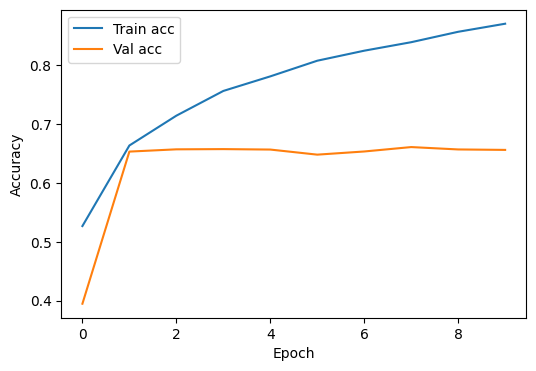

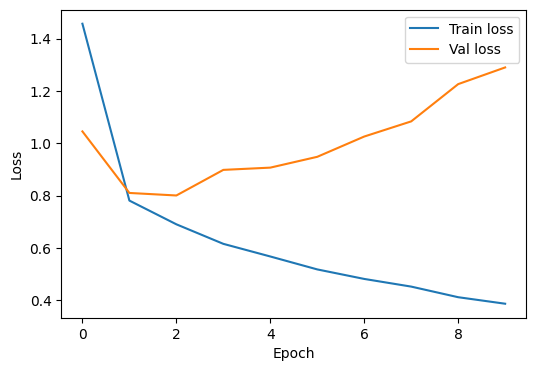

In [7]:
# =================================#
# 6.  Plot accuracy / loss curves  #
# =================================#
plt.figure(figsize=(6,4))
plt.plot(history.history["accuracy"],     label="Train acc")
plt.plot(history.history["val_accuracy"], label="Val acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(history.history["loss"],     label="Train loss")
plt.plot(history.history["val_loss"], label="Val loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.show()


In [8]:
# ==============================#
# 7.  Evaluate on the test set  #
# ==============================#
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest accuracy: {test_acc:.3f}")



Test accuracy: 0.643


In [9]:
# ======================================#
# 8.  Inference on custom written text  #
# ======================================#
INDEX2LABEL = {0: "negative", 1: "neutral", 2: "positive"}

samples = [
    "Utterly disappointing; the acting felt wooden.",
    "Let's play a game of chess instead.",
    "Can't wait to see the new movie!",
]

sample_pad = text_to_padded(samples)
probs      = model.predict(sample_pad, verbose=0)
preds      = probs.argmax(axis=1)

for txt, pred in zip(samples, preds):
    print(f"{txt[:60]:<60}  →  {INDEX2LABEL[pred]}")


Utterly disappointing; the acting felt wooden.                →  negative
Let's play a game of chess instead.                           →  neutral
Can't wait to see the new movie!                              →  positive


In [10]:
# ------------------------------------#
#  SAVE: model + tokenizer to disk    #
# ------------------------------------#
WEIGHTS_PATH    = "sentiment_bilstm_best.h5"      # weights‑only backup (optional)
TOKENIZER_PATH  = "tokenizer.json"                # vocabulary + config

# ▸ A. whole model (architecture + weights + optimizer state)
model.save(WEIGHTS_PATH)          # creates a directory with TF SavedModel format

# ▸ B. save the tokenizer (needed to pre‑process new text later)
# ✅  write the JSON string directly
with open(TOKENIZER_PATH, "w", encoding="utf-8") as f:
    f.write(tokenizer.to_json())



In [11]:
# ------------------------------------#
#  LOAD: model + tokenizer from disk  #
# ------------------------------------#
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import tokenizer_from_json

WEIGHTS_PATH    = "sentiment_bilstm_best.h5"      # weights‑only backup (optional)
TOKENIZER_PATH = "tokenizer.json"
MAX_LEN        = 200          # same padding length you trained with

# ▸ A. load the full model
loaded_model = tf.keras.models.load_model(WEIGHTS_PATH)

# ▸ B. load the tokenizer
with open(TOKENIZER_PATH, "r", encoding="utf-8") as f:
    token_json_str = f.read()          # read as raw string

loaded_tokenizer = tokenizer_from_json(token_json_str)


In [12]:
# ------------- quick sanity check ----------------
sample = ["What a wonderful day!"]
seq    = loaded_tokenizer.texts_to_sequences(sample)
padded = pad_sequences(seq, maxlen=MAX_LEN, padding="post", truncating="post")
pred   = loaded_model.predict(padded).argmax(axis=1)[0]

label_map = {0: "negative", 1: "neutral", 2: "positive"}
print("Predicted sentiment:", label_map[pred])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
Predicted sentiment: positive
